# Building a Classification Model and Explaining its Predictions for the Task of Rumour Verification

---

## Table of Contents

>[Building a Classification Model and Explaining its Predictions for the Task of Rumour Verification](#scrollTo=vL8Y3CYhBfwm)

>>[Table of Contents](#scrollTo=y5_bbLBvC7S7)

>>[Prepare your environment](#scrollTo=qTupgO23G9xv)

>>>[If Using Colab](#scrollTo=XEUIL1JjHFN8)

>>>[Install dependencies](#scrollTo=QHrvGjxkD-yI)

>>>[Import necessary packages](#scrollTo=X2lzRHP0NZEN)

>>[Task: Rumour Veracity Classification](#scrollTo=6tiGc2ibBzLH)

>>[Dataset](#scrollTo=6RR8bnB5a0Bf)

>>[Parameters](#scrollTo=hdbFUF_TFHKl)

>>[Model](#scrollTo=7Sv0gq8nEzew)

>>[Training](#scrollTo=FNCtKelwFAp0)

>>[Evaluation](#scrollTo=EjEAQrpyFD4x)

>>>[Cross-validation](#scrollTo=qwCqT5HOXQnK)

>>[Explaining Model Predictions](#scrollTo=PXBhI4eKAJkM)

>>>[LIME](#scrollTo=U12D0D5lONS5)

>>>[Layer Integrated Gradients](#scrollTo=6ujGtW2FONS8)



## Prepare your environment

### If Using Colab

Link Colab to your Google Drive to access and save files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Upload the data from your course to your Google Drive. For this notebook you will need *all-rnr-annotated-threads* folder.


If not using Colab, download the data from your course, place it in your working directory and update the filepaths in the notebook if necessary. 

### Install dependencies

In [ ]:
!pip install captum
!pip install spacy
!pip install torch
!pip install torchtext
!pip install transformers
!pip install pytorch_transformers
!pip install datasets
!pip install scikit-learn
!pip install scipy

### Import necessary packages

In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, AdamW, get_scheduler


from captum.attr import Lime, LimeBase, LayerIntegratedGradients
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json
import pickle
from copy import deepcopy
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter, OrderedDict

from tqdm.auto import tqdm
from IPython.core.display import HTML, display

## Task: Rumour Veracity Classification  


Social media platforms have gained popularity as news sources, often delivering updates faster than traditional media. The spread of unfiltered, often malicious posts carries a lot of risks. However, manual fact checking and verification cannot scale to address the amount of unverified information (rumours) circulating and cannot be easily performed in real-time. There is therefore increasing interest in machine learning (ML) and natural language processing (NLP) methods to assist with post verification. 

Here, **rumours** are defined as claims with unknown veracity value spreading on social media 

Rumour verification can be formulated as a classification problem, where a model is trained to predict if a rumour is **true, false or unverified**, given posts concerning a rumour as the input.


## Dataset


In this notebook we will use the **PHEMEPlus** dataset. 

This dataset contains Twitter conversations discussing rumours pertaining to five newsbreaking events as well as  external evidence from the wider web.

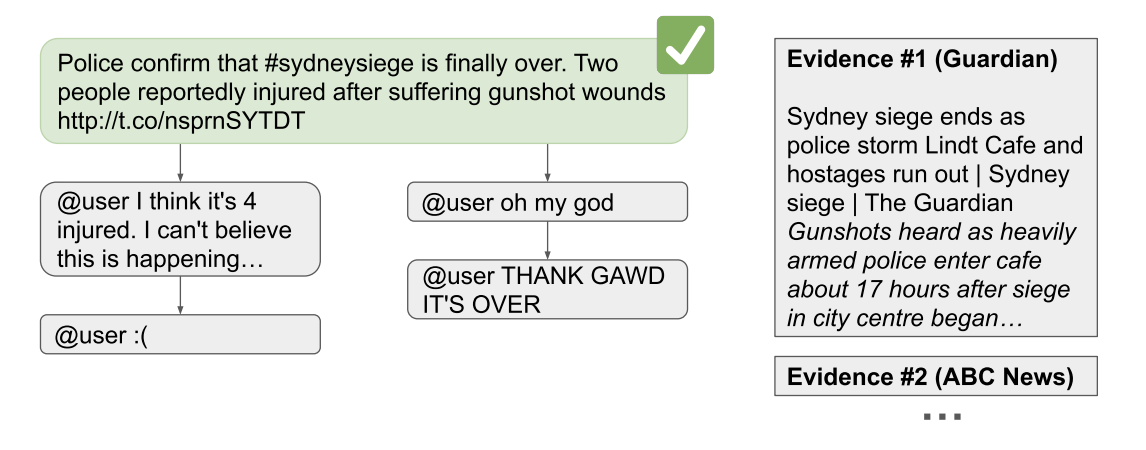

You can read more about the dataset in the ["PHEMEPlus: Enriching Social Media Rumour Verification with External Evidence"](https://aclanthology.org/2022.fever-1.6.pdf)

Load the dataset

In [ ]:
path_to_dataset = '/content/gdrive/My Drive/Colab Notebooks/data/phemeplus/PHEMEPlus_with_articles/all-rnr-annotated-threads' # path to the folder with the dataset
events = os.listdir(path_to_dataset)
#events = ['germanwings-crash-all-rnr-threads', 'ferguson-all-rnr-threads','charliehebdo-all-rnr-threads',
#          'ottawashooting-all-rnr-threads','sydneysiege-all-rnr-threads'] 

In [ ]:
events

['ottawashooting-all-rnr-threads',
 'sydneysiege-all-rnr-threads',
 'germanwings-crash-all-rnr-threads',
 'ferguson-all-rnr-threads',
 'charliehebdo-all-rnr-threads']

The all-rnr-annotated-threads directory has the following structure:

```
all-rnr-annotated-threads  
│
└───event_folder1 (ottawashooting-all-rnr-threads)
│   │   
│   │
│   └─── rumours 
│   │    │ 
|   |    └─── thread_folder1 (named after source tweet id)
│   │    │    │    structure.json
│   │    │    │    annotation.json
│   │    │    └─── source-tweets
│   │    │    └─── reactions
│   │    │    └─── web
│   │    │ 
|   |    └─── ...
│   │    │ 
|   |    └─── thread_folder_i 
│   │
│   └─── non-rumours (not using in this tutorial)
│       │   ...
│   ...
└───event_folder5 ('charliehebdo-all-rnr-threads')
  
```

The annotation.json file contains annotations that can be converted into veracity classification labels by using the following function:

In [ ]:
# function to convert tweet annotations to labels
def convert_annotations(annotation, string=False):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if (int(annotation['misinformation']) == 0) and (
                            int(annotation['true']) == 0):
            if string:
                label = "unverified"
            else:
                label = 2
        elif (int(annotation['misinformation']) == 0) and (
                              int(annotation['true']) == 1):
            if string:
                label = "true"
            else:
                label = 0
        elif (int(annotation['misinformation']) == 1) and (
                              int(annotation['true']) == 0):
            if string:
                label = "false"
            else:
                label = 1
        elif (int(annotation['misinformation']) == 1) and (
                              int(annotation['true']) == 1):
            print ("OMG! They both are 1! This shouldnt happen.")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
    elif ('misinformation' in annotation.keys()) and (
                      'true' not in annotation.keys()):
        if int(annotation['misinformation']) == 0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation']) == 1:
            if string:
                label = "false"
            else:
                label = 0

    elif ('true' in annotation.keys()) and (
          'misinformation' not in annotation.keys()):
        print ('Has true not misinformation')
        label = None
    else:
        print('No annotations')
        label = None
    return label

Load the dataset into a dictionary variable. As well as containing source tweets, the dataset contains responses to the source tweet and external evidence. For this part of the tutorial we will be only using the text of the source tweets. 


In [ ]:
cvfolds = {}
for fold in events:
    cvfolds[fold] = []
    path_to_rumours = os.path.join(path_to_dataset,fold,'rumours')
    threads = os.listdir(path_to_rumours)

    for thread in threads:
        conversation = {}
    
        path_to_source = os.path.join(path_to_rumours,thread,'source-tweets')
        src_tw_folder = os.listdir(path_to_source)
        path_to_source_tw = os.path.join(path_to_source,src_tw_folder[0]) # in case there are more than one tweet in source-tweet folder
        
        with open(path_to_source_tw) as f:
                for line in f:
                    src = json.loads(line)
                    
        #Filter out non-english tweets
        if src['lang']=='en':

            path_to_rnr_annotation = os.path.join(path_to_rumours,thread,'annotation.json')
            with open(path_to_rnr_annotation) as f:
                for line in f:
                    an = json.loads(line)
                    an['id'] = thread

            conversation['idx'] = int(thread)
            conversation['labels'] = convert_annotations(an,string = False)
            conversation['sentence1'] = src['text']
            cvfolds[fold].append(deepcopy(conversation))

Let's explore one of the instances from the dataset:

In [ ]:
print (cvfolds['sydneysiege-all-rnr-threads'][1])

{'idx': 544512691948498944, 'labels': 0, 'sentence1': 'Gunfire at Sydney cafe where hostages held; report says at least 1 person shot; more hostages flee http://t.co/Y62bZ2YYa5'}


For now, we choose one event from the dataset to be the testing set and the rest will form the training set. This is a challenging set up for the model as it havent seen any information or vocabulary about the test event during training.

In [ ]:
fold = 'sydneysiege-all-rnr-threads'

We are now preparing the dataset to be used with the model

In [ ]:
def prep_data(fold, cvfolds):
    
    test = {}
    test = cvfolds[fold]
    testset = Dataset.from_list(test)

    train = {}
    train = []
    for fo in list(cvfolds.keys()): 
        if fo!=fold:
            train.extend(cvfolds[fo])
    trainset = Dataset.from_list(train)
    
    return testset, trainset

In [ ]:
testset, trainset = prep_data(fold, cvfolds) # Form the train and test sets
testset_ids = list(testset['idx'])
print (len(testset_ids))

522


## Parameters

Set training parameters. These parameters affect model performance. You can assign one of the events in the dataset to be a development set and perform hyper-parameter tuning using it, i.e. changing the values of the hyper-parameters and observing how the performance on the development set changes, choosing the best performing parameter set to be used in the final model. It is important to use a separate development set for this process that we do not learn from the testing set.   

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 10
LEARN_RATE = 5e-5

## Model

You can choose any model to perform the classification task. Here, we will fine-tune a pretrained BERT model to perform veracity classification using source tweets. Huggignface library contains a variety of pre-trained models that can also be used for this purpose https://huggingface.co/models. You can choose another model (e.g. "roberta-base") and simply put its name into the chekpoint variable and test how the performance changes.

In [ ]:
checkpoint =  "bert-base-uncased" 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence1"], truncation=True) 

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_datasets = trainset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "idx"])
tokenized_datasets.set_format("torch")

tokenized_testset = testset.map(tokenize_function, batched=True)
tokenized_testset = tokenized_testset.remove_columns(["sentence1", "idx"])
tokenized_testset.set_format("torch",columns=['input_ids', 'attention_mask', 'labels']) 

train_dataloader = DataLoader(
    tokenized_datasets, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
eval_dataloader = DataLoader(
    tokenized_testset, batch_size=BATCH_SIZE, collate_fn=data_collator)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (device)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARN_RATE)
num_training_steps = N_EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=0,num_training_steps=num_training_steps)

## Training

In [ ]:
model.train()
progress_bar = tqdm(range(num_training_steps))
for epoch in range(N_EPOCHS):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/460 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Saving Model checkpoint

In [ ]:
savepath = "/content/gdrive/My Drive/Colab Notebooks/data/saved_model_"+fold
model.save_pretrained(savepath) 
tokenizer.save_pretrained(savepath)

Optionally, skip training and load the checkpoing provided to you

In [ ]:
savepath = "/content/gdrive/My Drive/Colab Notebooks/data/saved_model_"+fold
model = AutoModelForSequenceClassification.from_pretrained(savepath)
model.to(device)

## Evaluation

In [ ]:
metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
     
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.41762452107279696}

### Cross-validation

We have trained the model on four events and evaluated on another event, unseen during training. However, to get a more robust estimates of model performance we can perform leave-one-event-out cross-validation, i.e. loop over events and, at each loop iteration i, set event_i as testing, while using the other events for training the model. Then, model performance can be calculated as mean average of performance on each of the cross-validation folds. 

We do not include cross-validation loop in this tutorial due to potential computational constraints.

## Explaining Model Predictions




Now that we have trained our model and evaluated its performance on the testing set, we want to explore the reasons behind model's predicitons. For that we will use post-hoc local model explainability techniques. 

We will use Captum, a open source library that provides implementation of various interpretability methods for models implemented in PyTorch. More information and tutorials can be found on their website https://captum.ai/

In this tutorial we will consider two explainability approaches. LIME (https://captum.ai/api/lime.html) and Layer Integrated Gradients (https://captum.ai/api/layer.html#layer-integrated-gradients). 

### LIME

Lime is an interpretability method that trains an interpretable surrogate model by sampling points around a specified input example and using model evaluations at these points to train a simpler interpretable ‘surrogate’ model, such as a linear model.

Let's choose an instance that we want to see explained. For this example, let's choose an instance from the testing set that we inspected earlier.

In [ ]:
text = cvfolds['sydneysiege-all-rnr-threads'][15]['sentence1']
true_class = cvfolds['sydneysiege-all-rnr-threads'][15]['labels']
input_ids =  tokenizer.encode(text, add_special_tokens=True, return_tensors='pt').to(device) # convert text into model input format

In [ ]:
num2strlabel = {0:'True',1:'False',2:'Unverified'}

In [ ]:
print ("Tweet: ", text)
print ("This rumour is ", num2strlabel[true_class])
print ("The model predicts it as ", num2strlabel[int(torch.argmax(model(input_ids).logits))])

Tweet:  LIVE: Sydney cafe siege, hostages held in CBD, reporter @MarkDiStef at scene
http://t.co/NMbuLCimKV http://t.co/rNgNs107Xm
This rumour is  True
The model predicts it as  True


Next we outline functions that are necessary inputs to LIME method: function that measures the distance beetween embeddings as cosine similarity, function that creates input perturbation, utility functions. 

In [ ]:
# encode text indices into latent representations & calculate cosine similarity
def exp_embedding_cosine_distance(original_inp, perturbed_inp, _, **kwargs):
    original_emb = model(original_inp, output_hidden_states=True).hidden_states[-1][0,0,:]
    perturbed_emb = model(perturbed_inp, output_hidden_states=True).hidden_states[-1][0,0,:]
    #print(original_emb)
    #print(perturbed_emb)
    distance = 1 - F.cosine_similarity(original_emb, perturbed_emb, dim=0)
    return torch.exp(-1 * (distance ** 2) / 2)

# binary vector where each word is selected independently and uniformly at random
def bernoulli_perturb(text, **kwargs):
    probs = torch.ones_like(text) * 0.5
    output = torch.zeros_like(text)
    while torch.count_nonzero(output)<1:
      output = torch.bernoulli(probs).long()
    #print(output)
    return output

# remove absenst token based on the intepretable representation sample
def interp_to_input(interp_sample, original_input, **kwargs):
    return original_input[interp_sample.bool()].view(original_input.size(0), -1)

def forward_func(inputs):
  return model(inputs).logits

Create LIME instance

In [ ]:
lasso_lime_base = LimeBase(
    forward_func, 
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_embedding_cosine_distance,
    perturb_func=bernoulli_perturb,
    perturb_interpretable_space=True,
    from_interp_rep_transform=interp_to_input,
    to_interp_rep_transform=None
)

Use it to calculate LIME attributions to each input token

In [ ]:
attrs = lasso_lime_base.attribute(
    input_ids, # add batch dimension for Captum
    target=true_class,
    n_samples=32000,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime Base attribution: 100%|██████████| 32/32 [00:02<00:00, 13.15it/s]


Attribution range: -0.9552779793739319 to 2.3359923362731934


In [ ]:
raw_input = tokenizer.convert_ids_to_tokens(input_ids.tolist()[0])
raw_input = [x.strip("G") for x in raw_input]
dict(zip(raw_input, attrs.tolist()))

{'[CLS]': 0.0,
 'live': -0.0,
 ':': -0.08307922631502151,
 'sydney': 0.2065686732530594,
 'cafe': -0.0,
 'siege': 0.9488512873649597,
 ',': -0.0,
 'hostages': 1.2953333854675293,
 'held': 2.3359923362731934,
 'in': -0.9552779793739319,
 'cb': -0.0,
 '##d': 0.0,
 'reporter': 0.0,
 '@': -0.23986968398094177,
 'mark': 0.0,
 '##dis': 0.19010986387729645,
 '##te': -0.5912904143333435,
 '##f': 0.0,
 'at': -0.0,
 'scene': 0.0,
 'http': 0.008073979057371616,
 '/': -0.0,
 't': -0.2453169971704483,
 '.': 0.0,
 'co': 0.0,
 'nm': 0.0,
 '##bu': 0.0,
 '##lc': 0.0,
 '##im': -0.3891563415527344,
 '##k': -0.0,
 '##v': 0.0,
 'rn': 0.0,
 '##gn': -0.0,
 '##s': 0.0,
 '##10': -0.4124566912651062,
 '##7': -0.0,
 '##x': 0.0,
 '##m': 0.3789188861846924,
 '[SEP]': -0.0}

Visualization to highlight the influential words where green stands for positive correlation and red for negative.

In [ ]:
def show_text_attr(scores, raw_input):
    rgb = lambda x: '255,0,0' if x < 0 else '0,255,0'
    alpha = lambda x: abs(x) ** 0.5
    token_marks = [
        f'<mark style="background-color:rgba({rgb(attr)},{alpha(attr)})">{token}</mark>'
        for token, attr in zip(raw_input, scores.tolist())
    ]
    
    display(HTML('<p>' + ' '.join(token_marks) + '</p>'))

In [ ]:
show_text_attr(attrs, raw_input)

### Layer Integrated Gradients

Integrated Gradients is an axiomatic model interpretability algorithm that attributes / assigns an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs along the path (straight line) from given baselines / references to inputs.

Layer Integrated Gradients is a variant of Integrated Gradients that assigns an importance score to layer inputs or outputs.

In [ ]:
def make_encodings(text):
  pad_id = tokenizer.pad_token_id
  cls_id = tokenizer.cls_token_id
  sep_id = tokenizer.sep_token_id
  input_ids = tokenizer.encode(text, add_special_tokens=False)
  base_ids = [pad_id]*len(input_ids)
  input_ids = [cls_id]+input_ids+[sep_id]
  base_ids = [cls_id]+base_ids+[sep_id]
  return torch.LongTensor([input_ids]).to(device), torch.LongTensor([base_ids]).to(device)

In [ ]:
input_ids, base_ids = make_encodings(text)

In [ ]:
layer = model.bert.embeddings
ig = LayerIntegratedGradients(forward_func, layer)

In [ ]:
attrs, delta = ig.attribute(inputs = input_ids, 
                            baselines=base_ids, 
                            target=true_class, 
                            return_convergence_delta=True) 

In [ ]:
scores = attrs.sum(dim=-1)
scores = (scores - scores.mean()) / scores.norm()
scores = scores[0]

In [ ]:
#dict(zip(raw_input, scores))

In [ ]:
show_text_attr(scores, raw_input)

We can see that different explainability techniques can provide different weight attributions to the input tokens, therefore it is important to understand the explainbility mechanism used to interpret its output.

In this tutorial we have learned to train a rumour verificaiton model and inspect its predictions using two explainability techniques. 